## 1.Data analysis - Malta Airbnb

In [1]:
## Import libraries
import pandas as pd 
import numpy as np

import csv

#Natural Language processing 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


## Data visualization
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
## Load data
## http://insideairbnb.com/get-the-data.html 28 DEC 2021 LAST COMPILED
## https://github.com/Lukastuong123/Python/blob/master/Project-%20Airbnb%20(Python-%20Interactive%20Map%2C%20Natural%20Language%20Processing%2C%20Comparative%20Study%2C%20Regression)/Project.%20AirBnB%20Part%20B%20(Python-%20Interactive%20Map%2C%20Natural%20Language%20Processing)%20.ipynb

listings = pd.read_csv('./Data/listings.csv')
reviews = pd.read_csv('./Data/reviews.csv')
listings_summary = pd.read_csv('./Data/listings_summary.csv')

In [21]:
## Check detailed listings dataframe
listings.head()

,id,listing_url,scrape_id,last_searched,last_scraped,name,description,neighborhood_overview,picture_url,host_id,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,region_id,region_name,region_parent_id,region_parent_name,region_parent_parent_id,region_parent_parent_name,reviews_per_month
0,53988243,https://www.airbnb.com/rooms/53988243,20211228232058,2021-12-28,2021-12-30,Brand-new shared one-bedroom apartment (only g...,In the middle of San Julian and Sliema. Bus st...,NaN,https://a0.muscache.com/pictures/d5fd9439-76bc...,49911004,...,0,0,1,MT01253,San Gwann,NaN,NaN,NaN,NaN,NaN
1,39695529,https://www.airbnb.com/rooms/39695529,20211228232058,2021-12-28,2021-12-30,modern apartment,the apartment is very big and modern and its i...,mini market in 2 min walk <br />super market 1...,https://a0.muscache.com/pictures/e41a92fc-c010...,217804068,...,1,1,0,MT01310,Zejtun,NaN,NaN,NaN,NaN,NaN
2,11579194,https://www.airbnb.com/rooms/11579194,20211228232058,2021-12-28,2021-12-30,The Residence 03 - University area,The Residence is located within the upmarket H...,The Residence is located within the upmarket H...,https://a0.muscache.com/pictures/d7d822dd-3031...,57084556,...,0,7,0,MT01253,San Gwann,NaN,NaN,NaN,NaN,0.19
3,23363846,https://www.airbnb.com/rooms/23363846,20211228232058,2021-12-28,2021-12-30,"Full Air-conditioned, 2 Bedroom Apt.",An 80sqm 2 bedroom apartment in the South of M...,The apartment on top lives an Sicilian family....,https://a0.muscache.com/pictures/bca21e3d-f0e5...,31383964,...,1,0,0,MT01310,Zejtun,NaN,NaN,NaN,NaN,0.97
4,33903128,https://www.airbnb.com/rooms/33903128,20211228232058,2021-12-28,2021-12-30,Village Knights B&B - Valletta Room,"A luxury, authentic, house of character in the...","Just a 4 min walk up the road to the centre, o...",https://a0.muscache.com/pictures/94dc5710-ec97...,239349288,...,0,1,0,MT01407,Zebbug (Malta),NaN,NaN,NaN,NaN,NaN


In [3]:
## Check reviews dataframe
reviews.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,637763,2173360,2012-09-02,3250724,Naoufal,My stay here was à lot better than I expected!...
1,637763,2490468,2012-10-02,2678469,Joey,This was an absolutely delightful place to sta...
2,637763,2597919,2012-10-13,3679703,Katerina,My boyfriend and I stayed at Stefania's place ...
3,637763,4075716,2013-04-08,4180801,Philippe,very nice place to visit Malta. The house is c...
4,637763,4178698,2013-04-16,4902150,Roman,War alles gut bei Stefania. Sehr freundlich un...


In [ ]:
## Check columns related to reviews from listings df
reviews_cols = [col for col in listings.columns if 'review' in col]
print(reviews_cols)

In [4]:
## Check information about data type 

#listings.info()
## 8406 unique listings ID

reviews.info()
## 173180 comments

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173180 entries, 0 to 173179
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     173180 non-null  int64 
 1   id             173180 non-null  int64 
 2   date           173180 non-null  object
 3   reviewer_id    173180 non-null  int64 
 4   reviewer_name  173180 non-null  object
 5   comments       173093 non-null  object
dtypes: int64(3), object(3)
memory usage: 7.9+ MB


In [11]:
## Check for duplicates in listingd id
print("Number of unique listings id is:", listings.id.nunique())

## Unique number of host_id - 3678
print("Number of unique hosts id is:", listings.host_id.nunique())

## There are 8406 properties belonging to 3678 owners.


Number of unique listings id is: 8406
Number of unique hosts id is: 3678


In [42]:
## room_type vs. property_type
listings.room_type.nunique() #4
listings.property_type.nunique() #67
## choosing room_type, it's better grouped

listings.room_type.value_counts() 
## Entire home/apt seems to be the most common. It represents almost 65% of the sample, while private room 31%

Entire home/apt    5433
Private room       2614
Shared room         230
Hotel room          129
Name: room_type, dtype: int64

In [41]:
## for region_type
listings.region_name.nunique() #68

68

In [30]:
## Save column names in separate df to take a look at them
colnames_listingDf = np.array(listings.columns)
df_colnames = pd.DataFrame(data=colnames_listingDf)
df_colnames = df_colnames.rename(columns = {0: 'Colname'}, inplace=False)

In [3]:
## Select columns to further analyse
necessary_columns = ['id', 'name', 'host_id',  'host_since', 'host_is_superhost', 'host_response_rate', 
                     'room_type', 'accommodates', 'minimum_nights', 'first_review', 'last_review', "price",
                     'review_scores_rating', 'calculated_host_listings_count', 'region_name', 'number_of_reviews']

## reviews_scores_rating was checked by looking at airbnb website

listings2 = listings.loc[:, listings.columns.isin(necessary_columns)]

In [4]:
## Convert price type to float
listings2.price = listings2.price.str.replace("[$, ]", "") ## remove '$' and ',' signs
listings2.price =listings2.price.astype('float') ## convert
listings2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              8406 non-null   int64  
 1   name                            8405 non-null   object 
 2   host_id                         8406 non-null   int64  
 3   host_since                      8406 non-null   object 
 4   host_response_rate              6400 non-null   object 
 5   host_is_superhost               8406 non-null   object 
 6   room_type                       8406 non-null   object 
 7   accommodates                    8406 non-null   int64  
 8   price                           8406 non-null   float64
 9   minimum_nights                  8406 non-null   int64  
 10  number_of_reviews               8406 non-null   int64  
 11  first_review                    6414 non-null   object 
 12  last_review                     64

<ipython-input-4-83c5eeba5965>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  listings2.price = listings2.price.str.replace("[$, ]", "") ## remove '$' and ',' signs
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [29]:
## Descriptive statistics
dataDescrib = listings2.describe()
dataDescrib

,id,host_id,accommodates,price,minimum_nights,number_of_reviews,review_scores_rating,review_scores_value,calculated_host_listings_count
count,8.406000e+03,8.406000e+03,8406.000000,8406.000000,8406.000000,8406.000000,6414.000000,6339.000000,8406.000000
mean,3.262605e+07,1.413875e+08,4.051511,100.818463,4.507733,20.601951,4.608499,4.641647,28.538663
std,1.547576e+07,1.205963e+08,2.524990,134.170182,23.695342,37.068934,0.690997,0.472872,81.324078
min,5.018800e+04,5.900800e+04,1.000000,8.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,2.016570e+07,3.039001e+07,2.000000,44.000000,1.000000,1.000000,4.530000,4.540000,1.000000
50%,3.496828e+07,1.184890e+08,4.000000,70.000000,2.000000,5.000000,4.800000,4.750000,3.000000
75%,4.718476e+07,2.225276e+08,6.000000,118.000000,3.000000,23.000000,5.000000,4.930000,11.000000
max,5.403093e+07,4.362538e+08,16.000000,4500.000000,1000.000000,427.000000,5.000000,5.000000,380.000000


In [35]:
## Group by property type
listings2.groupby(['room_type'])['number_of_reviews'].describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,5433.0,23.991533,39.584150,0.0,1.0,8.0,29.00,427.0
Hotel room,129.0,8.682171,12.584703,0.0,1.0,4.0,10.00,63.0
Private room,2614.0,15.527544,32.646781,0.0,0.0,2.0,15.00,306.0
Shared room,230.0,4.891304,11.030779,0.0,0.0,1.0,3.75,96.0


In [7]:
## Top neighbourhoods by number of reviews
listings2.groupby(['region_name'])['number_of_reviews'].size().sort_values(ascending=False).head(10)

region_name
Sliema               984
San Giljan           942
San Pawl il-Bahar    823
Valletta             506
Mellieha             423
Gzira                359
Swieqi               344
Zebbug (Ghawdex)     315
Msida                308
Marsascala           264
Name: number_of_reviews, dtype: int64

In [13]:
## Top 10 neighbourhoods by average host score
a = listings2.groupby(['region_name'])['review_scores_rating'].mean().sort_values(ascending=False).head(10)
print(a)

region_name
Santa Lucija    4.930000
Mqabba          4.925000
Lija            4.923333
Safi            4.912000
Kirkop          4.903333
Dingli          4.890000
Mtarfa          4.885000
Marsa           4.882500
Xghajra         4.867333
Mdina           4.839231
Name: review_scores_rating, dtype: float64


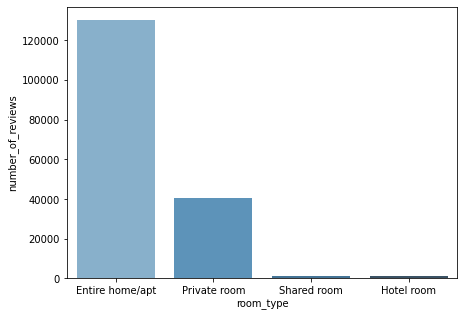

In [68]:
room_types_reviews = listings2.groupby(['room_type']).agg({'number_of_reviews': pd.Series.sum})
#room_types_reviews = listings.groupby(['room_type']).size().sort_values(ascending=False)
room_types_reviews = room_types_reviews.reset_index()
room_types_reviews.sort_values("number_of_reviews", ascending=False, inplace=True)
#room_types_reviews.info()

plt.figure(figsize=(7,5))
p1 = sns.barplot(x = 'room_type', y = "number_of_reviews", data = room_types_reviews, palette="Blues_d")


In [14]:
## Data binning - price
# Price ranges (8$ - 4500$)

## 1. Manually adjusting 
#bins = np.linspace(listings2.price.min(), listings2.price.max(), 3)
labels = [1,2,3,4,5,6]
#bins = [8, 100, 250, 500, 1000, 4500] ## initial vals.
bins = [8, 50, 100, 300, 500, 1000, 4500]
df = listings2
df['bin_cut'] = pd.cut(df.price, bins=bins, labels = labels, include_lowest=True)


<ipython-input-14-4162d783c3fa>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin_cut'] = pd.cut(df.price, bins=bins, labels = labels, include_lowest=True)


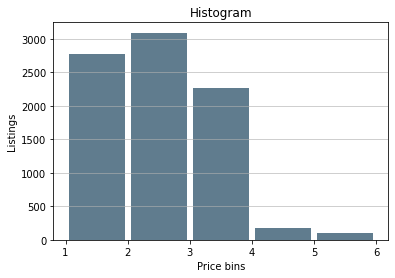

In [88]:
#plt.hist(df['bin_cut'], bins =5)

plt.hist(df['bin_cut'], bins=5, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram')
plt.xlabel('Price bins')
plt.ylabel('Listings')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [27]:
df.bin_cut.value_counts()

2    3093
1    2775
3    2263
4     178
5      71
6      26
Name: bin_cut, dtype: int64

In [ ]:
## Using np.linspace to compare bins
# bins = np.linspace(listings2.price.min(), listings2.price.max(), 6)
# bins

In [ ]:
## Jenkspy method
import jenkspy
breaks = jenkspy.jenks_breaks(df['price'], nb_class=6)
df['bin_cut_jenkspy'] = pd.cut(df['price'] , bins=breaks, labels=labels, include_lowest=True)
df.bin_cut_jenkspy.value_counts()

In [29]:
## Number of reviews in these price intervals
df.groupby(['bin_cut'])['number_of_reviews'].size().sort_values(ascending=False)

# The highest number of reviews in 50$ - 100$ price range

bin_cut
2    3093
1    2775
3    2263
4     178
5      71
6      26
Name: number_of_reviews, dtype: int64

In [36]:
## nunique returns a series. agg returns a df
reviews_check = reviews.groupby('listing_id').agg({'comments': pd.Series.nunique}) ##6428

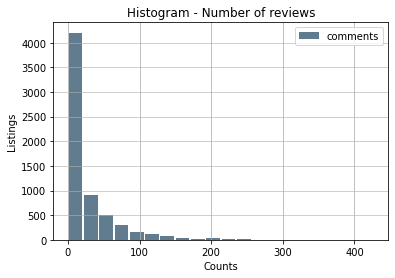

In [33]:
# Histogram - number of reviews
#size, scale = 1000, 10
reviews_check.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram - Number of reviews')
plt.xlabel('Counts')
plt.ylabel('Listings')
plt.grid(axis='y', alpha=0.75)

In [37]:
## Select listings with >= n reviews
reviews_check = reviews_check[reviews_check.comments >=10] ##2349 listings with >=20 comments. 3409 with >= 10 comments.

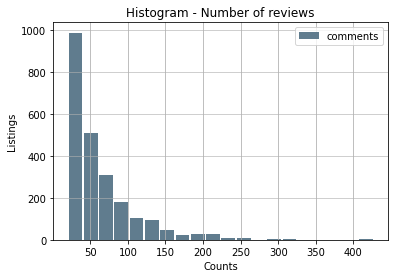

In [35]:
# size, scale = 1000, 10
reviews_check.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram - Number of reviews')
plt.xlabel('Counts')
plt.ylabel('Listings')
plt.grid(axis='y', alpha=0.75)

In [39]:
del reviews_check

In [38]:
## Under 10 reviews dataframe - keep them in case I need them later
under_10_reviews = listings2[listings2.number_of_reviews < 10] ## 4997

In [40]:
## Keep listings with >= 10 reviews
listings2 = listings2[listings2.number_of_reviews >= 10] ## 3409

## Reviews analysis

In [41]:
## Take a look at reviews
reviews.comments.values[5]

"Brilliant! While on vacation using Airbnb, I am looking for a clean comfortable room, good location and nice host. Stefania's triumphs in all three categories. Location can not be any better. It is 5-6 minutes walk of both sides of Sliema's water front; Sliema Ferry on one side is where all your bus and sea-bound tours start from (as well as the ferry to Valleta) and on the north side, border with San Julian, where there are even more eateries and night life. Rooms are large and spotlessly clean and bathrooms are newly remodeled. House is a typical local house tucked in a small, quiet residential area, that will remain quiet even in high tourism season (while being minutes away from the hassle and bustle). Upper floor provides the guest with total privacy and even their own small kitchen. Stefania is a gracious and superb host, and will sure take extremely good care of you. Highly recommended! Thanks Stefania for superb hospitality."

In [45]:
print(len(reviews.comments.values[5])) ## 946 words

946


In [42]:
## Convert comments to string
reviews['comments'] = reviews['comments'].astype('string') 

In [44]:
## Rename id to listing_id
listings2 = listings2.rename(columns={'id' : 'listing_id'})

## Merge listings2 data frame with reviews table
listings3 = pd.merge(listings2, reviews, how = 'left', on = "listing_id", suffixes=('', '_y')) 

In [45]:
## Top 10 hosts from Malta based on number of reviews
top_10_hosts = listings3.groupby('host_id').size().sort_values(ascending = False).to_frame(name = 'reviews_number').head(10)
top_10_hosts

,reviews_number
host_id,
14163414,1543
3585451,1250
4214727,1235
577652,1210
2442805,1058
16573646,1048
1351697,891
219295979,869
1218900,867


In [47]:
## Data preparation - comments column

#1. Remove empty comments #173180 obs. initially
listings3 = listings3[listings3['comments'].notnull()]

#2. Convert to lower case
listings3['comments'] = listings3['comments'].str.lower()

#3. Remove numbers
listings3['comments'] = listings3['comments'].str.replace('\d+', '')

# listings3['comments'] = listings3['comments'].str.rstrip(string.digits)

## 4. Remove punctuation (regex method)
listings3.comments = listings3.comments.str.replace("[^\w\s]", "")

## 5. Replace double spaces with single space
listings3.comments = listings3.comments.str.replace('\s+', ' ')

<ipython-input-47-1176f6744fd1>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  listings3['comments'] = listings3['comments'].str.replace('\d+', '')
<ipython-input-47-1176f6744fd1>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  listings3.comments = listings3.comments.str.replace("[^\w\s]", "")
<ipython-input-47-1176f6744fd1>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  listings3.comments = listings3.comments.str.replace('\s+', ' ')


In [49]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

## List of stopwords
stopwords = stopwords.words("english")
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


In [50]:
## Use nltk library to remove unecessary information (stopwords)
#stopwords = stopwords.words["english"]
listings3.comments = listings3.comments.apply(lambda x: " ".join([i for i in x.split()
                                            if i not in (stopwords)]))

In [ ]:
from nltk import sent_tokenize
nltk.download('punkt')

In [ ]:
## Top words used in reviews
# feedback = listings3.comments.to_list()

# vec = CountVectorizer().fit(feedback)
# bag_of_words = vec.transform(feedback)
# sum_words = bag_of_words.sum(axis=0)
# words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]


# cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
# cvec_df.head(10)

In [54]:
## Top words used in reviews

from nltk.probability import FreqDist

## convert to list
feedback_list = listings3.comments.to_list()
## convert list into string
feedback_list2 = ' '.join(feedback_list) 

## tokenize the string
tokens = nltk.word_tokenize(feedback_list2) 
## words frequency
wordsFrequency = FreqDist(tokens) 
print(wordsFrequency .most_common(10))

[('apartment', 65046), ('great', 63248), ('place', 53305), ('stay', 51368), ('de', 44211), ('location', 40789), ('us', 40373), ('nice', 37941), ('et', 35380), ('clean', 34862)]


In [56]:
## Display the result in a nicer format
wordsFreq_df = pd.DataFrame(wordsFrequency.most_common(10),
                                     columns=["Word", "Frequency"])
wordsFreq_df.head(10)

,Word,Frequency
0,apartment,65046
1,great,63248
2,place,53305
3,stay,51368
4,de,44211
5,location,40789
6,us,40373
7,nice,37941
8,et,35380
9,clean,34862


In [ ]:
## Plot
top_10 = wordsFrequency.most_common(5)
top_10 = pd.Series(dict(wordsFrequency))
fig, ax =plt.subplots(figsize = (10,10))

## Seaborn
plot_fig = sns.barplot(x = top_10.index, y = top_10.values, ax=ax)
plt.xticks(rotation=30)

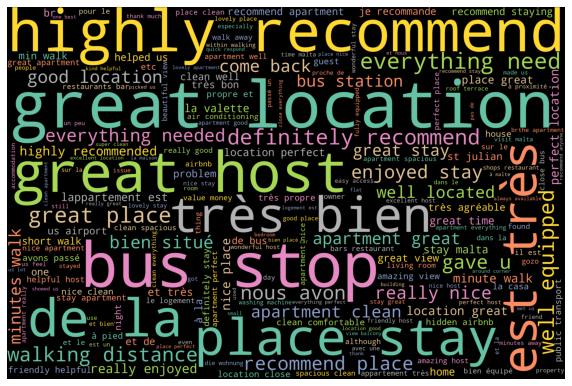

In [66]:
## Wordcloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2').generate(feedback_list2)

plt.figure(figsize= (10,10))
plt.imshow(wordcloud)

plt.axis("off")
plt.show()


In [61]:
 from PIL import Image
 from wordcloud import ImageColorGenerator

In [ ]:
## Wordcloud customized

## generate a word cloud image
mask = np.array(Image.open("./cartoon-clouds-png.png")) ## use other img
wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(feedback_list2)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
# store to file
plt.savefig("cloud1.png", format="png") 
plt.show()


In [70]:
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


In [74]:
## Most common expressions
nltk.download('genesis')
from nltk.collocations import *

bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

finder = BigramCollocationFinder.from_words(listings3["comments"].values.reshape(-1, ))
# finder = BigramCollocationFinder.from_documents(listings3["comments"]), same but slower 

# only bigrams that appear 3+ times
finder.apply_freq_filter(3)

# # return the 10 n-grams with the highest PMI
finder.nbest(bigram_measures.pmi, 10)


In [89]:
bckup = listings3

In [93]:
## Eliminate sentence from df
listings3['Comments_cleaned'] = listings3['comments'].map(lambda x: x.lstrip('+-').rstrip('host canceled reservation days arrival automated posting'))


In [94]:
finder = BigramCollocationFinder.from_words(listings3["Comments_cleaned"].values.reshape(-1, ))
# finder = BigramCollocationFinder.from_documents(listings3["comments"]), same but slower 

# only bigrams that appear 3+ times
finder.apply_freq_filter(3)

# # return the 10 n-grams with the highest PMI
finder.nbest(bigram_measures.pmi, 10)


[('amaz', 'amaz'),
 ('', 'graz'),
 ('', 'nice apartment w'),
 ('', 'perfect thank'),
 ('', 'lik'),
 ('nice coz', ''),
 ('amazing view', ''),
 ('aw', ''),
 ('', 'w'),
 ('', 'enj')]

In [ ]:
## De aflat:
## 1. Cate proprietati detin
## 2. Top cuvinte
## 3. Tip proprietate
## 4. Preturi
## 5. Interval de timp
## 6. review-uri per tip proprietate? cate ca si numar.
## 7. reviewuri per scor si proprietate? 
## 8. pers cu highest number of reviews & scor?
## 9. comp. cuvinte intre cei care au scor >4 si care au <=4.
## 10. sintagme populare
## 11. topic modelling https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
## 12. sentiment analysis https://livebook.manning.com/book/real-world-machine-learning/chapter-8/25